# How to use Persine to scrape and analyze YouTube recommendations

[Persine](https://github.com/jsoma/persine) is an automated tool to study and reverse-engineer algorithmic recommendation systems. It's meant to be super simple and super reproducible.

## Installation and setup

We'll start by installing Persine.

In [ ]:
pip install persine

     |████████████████████████████████| 2.8MB 5.4MB/s 
     |████████████████████████████████| 911kB 51.8MB/s 


Next we need to install Chromium and chromedriver, which will allow us to pretend to be a browser. Chromium is the basis for Chrome, so you can think of this as just installing Chrome.

In [ ]:
!apt-get -qq update # to update ubuntu to correctly run apt install
!apt -qq install chromium-chromedriver

chromium-chromedriver is already the newest version (87.0.4280.66-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


# How to use Persine

## Visiting pages and scraping recommendations

We'll tell Persine to start up a new session, watch [this video](https://www.youtube.com/watch?v=oFeoS41xe7w"), then click the "next up" button 3 times. _Notice how nice and easy and shareable the commands are to make that happen!_

This might take a little while. When it's all done, we'll save the history and recommendations to CSV files. 

In [ ]:
from persine import PersonaEngine

engine = PersonaEngine(headless=True)

with engine.persona() as persona:
    persona.run_batch([
        "https://www.youtube.com/watch?v=oFeoS41xe7w",
        "youtube:next_up#3"
    ])
    persona.history.to_csv("history.csv")
    persona.recommendations.to_csv("recs.csv")


# Analyzing the results

Even though we're outside of the `with`, we can still look at the history and recommendations associated with the session. Since we love truth and beauty we're going to look at them both as pandas dataframes.

## History

The **history** is a list of every page you visited and every action you took. In this case, we'll have four items - the first page we visited, and one row for each of the "next up" videos we watched.

In [ ]:
history = persona.history.to_df()
history

,key,action,page_title,url,date,url_before_action,channel_sub_count,channel_url,dislike_count,is_listed,is_live,like_count,posted_on,view_count,page_type,title,id,channel_name,recommendations,caption_tracks
0,2021-02-19-21.57.08.848,https://www.youtube.com/watch?v=oFeoS41xe7w,James Baldwin Debates William F. Buckley (1965...,https://www.youtube.com/watch?v=oFeoS41xe7w,2021-02-19 21:57:08,None,33.3K subscribers,https://www.youtube.com/channel/UCGm5Oqp5rAbaC...,"1,218 dislikes",True,False,"42,670 likes","Oct 27, 2012","2,688,658 views",video,James Baldwin Debates William F. Buckley (1965),oFeoS41xe7w,The Riverbends Channel,"[{'channel_name': 'PBS NewsHour', 'duration_te...",[]
1,2021-02-19-21.57.16.723,youtube:next_up,Baldwin-Buckley race debate still resonates 55...,https://www.youtube.com/watch?v=MRzkHgMaPL4,2021-02-19 21:57:16,https://www.youtube.com/watch?v=oFeoS41xe7w,2.51M subscribers,https://www.youtube.com/channel/UC6ZFN9Tx6xh-s...,564 dislikes,True,False,"17,254 likes","Feb 16, 2020","865,288 views",video,Baldwin-Buckley race debate still resonates 55...,MRzkHgMaPL4,PBS NewsHour,"[{'channel_name': 'ThamesTv', 'duration_text':...","[{'displayName': 'English', 'id': None, 'is_de..."
2,2021-02-19-21.57.28.504,youtube:next_up,Civil Rights | James Baldwin Interview | Mavis...,https://www.youtube.com/watch?v=3Wht4NSf7E4,2021-02-19 21:57:28,https://www.youtube.com/watch?v=MRzkHgMaPL4,237K subscribers,https://www.youtube.com/channel/UChXQL4MqC4ihS...,140 dislikes,True,False,"7,656 likes","Nov 2, 2014","389,920 views",video,Civil Rights | James Baldwin Interview | Mav...,3Wht4NSf7E4,ThamesTv,"[{'channel_name': 'ProjectDystopia', 'duration...",None
3,2021-02-19-21.57.36.443,youtube:next_up,"JAMES BALDWIN: Interview (Florida Forum, Miami...",https://www.youtube.com/watch?v=FpRziHGxeEU,2021-02-19 21:57:36,https://www.youtube.com/watch?v=3Wht4NSf7E4,3.19K subscribers,https://www.youtube.com/channel/UCPJmIZRzmL_4r...,62 dislikes,True,False,"2,303 likes","Nov 24, 2011","173,488 views",video,"JAMES BALDWIN: Interview (Florida Forum, Miami...",FpRziHGxeEU,ProjectDystopia,"[{'channel_name': 'thepostarchive', 'duration_...",None


## Recommendations

The **recommendations** are every item suggested by YouTube. This includes everything in video sidebars, search results pages, and the youtube homepage. Oddly our ads seems to be about bikinis and cruise lines, so we'll filter those out before we do our analysis.

In [ ]:
recs = persona.recommendations.to_df()
recs = recs[~recs.item_type.str.startswith('YTD-PROMOTED')]
recs

,channel_name,duration_text,item_type,metadata,position,thumbnail_url,title,url,action_key
0,PBS NewsHour,9:00,YTD-COMPACT-AUTOPLAY-RENDERER,865K views\n1 year ago,1,https://i.ytimg.com/vi/MRzkHgMaPL4/hqdefault.j...,Baldwin-Buckley race debate still resonates 55...,https://www.youtube.com/watch?v=MRzkHgMaPL4,2021-02-19-19.38.31.994
1,Ayn Rand Institute,26:39,YTD-COMPACT-VIDEO-RENDERER,426K views\n7 months ago,2,https://i.ytimg.com/vi/lHl2PqwRcY0/hqdefault.j...,The Mike Wallace Interview with Ayn Rand,https://www.youtube.com/watch?v=lHl2PqwRcY0,2021-02-19-19.38.31.994
2,"Firing Line with William F. Buckley, Jr.",52:04,YTD-COMPACT-VIDEO-RENDERER,308K views\n4 years ago,3,https://i.ytimg.com/vi/NxpuT1SNurU/hqdefault.j...,Firing Line with William F. Buckley Jr.: Muham...,https://www.youtube.com/watch?v=NxpuT1SNurU,2021-02-19-19.38.31.994
3,CBC,7:49,YTD-COMPACT-VIDEO-RENDERER,3.7M views\n10 years ago,4,https://i.ytimg.com/vi/C7IJ7npTYrU/hqdefault.j...,"Malcolm X on Front Page Challenge, 1965: CBC A...",https://www.youtube.com/watch?v=C7IJ7npTYrU,2021-02-19-19.38.31.994
4,The Dick Cavett Show,12:58,YTD-COMPACT-VIDEO-RENDERER,390K views\n6 months ago,5,https://i.ytimg.com/vi/hzH5IDnLaBA/hqdefault.j...,James Baldwin and Paul Weiss Debate Discrimina...,https://www.youtube.com/watch?v=hzH5IDnLaBA,2021-02-19-19.38.31.994
...,...,...,...,...,...,...,...,...,...
77,GREATBLACKSHARK,51:11,YTD-COMPACT-VIDEO-RENDERER,135K views\n11 months ago,17,,MALCOLM X & JAMES BALDWIN DISCUSS RACE RELATIO...,https://www.youtube.com/watch?v=ppTj_eDfXSY,2021-02-19-19.38.55.186
78,reelblack,28:37,YTD-COMPACT-VIDEO-RENDERER,1.4M views\n2 years ago,18,,Malcolm X | City Desk (1963),https://www.youtube.com/watch?v=M7SgS2yPRF0,2021-02-19-19.38.55.186
79,KELLIEBREW’S WORLD,51:11,YTD-COMPACT-VIDEO-RENDERER,26K views\n8 months ago,19,,“WE ARE NOT WILLING TO WAIT ANOTHER 1000 YEARS...,https://www.youtube.com/watch?v=pU-VsSprPgQ,2021-02-19-19.38.55.186
80,reelblack,28:33,YTD-COMPACT-VIDEO-RENDERER,263K views\n6 days ago,20,,Fred Hampton Documentary (1990) | COINTELPRO B...,https://www.youtube.com/watch?v=PV-0FODvq_w,2021-02-19-19.38.55.186


## Using the history and recommendations

We can analyze them separately, for example finding out what channels the most recommended videos were from.

In [ ]:
recs.channel_name.value_counts().nlargest(10)

thepostarchive                              21
The Dick Cavett Show                         6
reelblack                                    5
Firing Line with William F. Buckley, Jr.     5
AfroMarxist                                  3
CBC                                          2
The Riverbends Channel                       2
Netflix Film Club                            2
Dartmouth                                    2
KELLIEBREW’S WORLD                           2
Name: channel_name, dtype: int64

Or maybe we're interested in the videos themselves, like "even though we start with a video in 2012, when did the 'next up' videos get posted?"

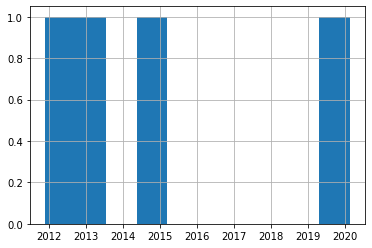

In [ ]:
import pandas as pd

# That first year on the far left is the one from our first video
pd.to_datetime(history.posted_on).hist()

We can combine the results with other tools, like the natural language processing tool [spaCy](https://spacy.io/). We can use its Named Entity Recognition to ask "who are the people mentioned in the titles of the recommended videos?"

In [ ]:
import spacy
from collections import Counter

# Download a spacy model for processing English
nlp = spacy.load("en_core_web_sm")

# Clean up the titles a bit, removing - and 's which mess up NER a little
cleaned_titles = recs.title.str.replace("-", "").str.replace("'s", "")
texts = '. '.join(cleaned_titles)

# Feed it to spaCy, get all of the people back
doc = nlp(texts)
entities = [e.text for e in doc.ents if e.label_ == 'PERSON']

# Who are the most 15 common?
Counter(entities).most_common(15)

[('James Baldwin', 31),
 ('Malcolm X', 7),
 ('Firing Line', 6),
 ('William F. Buckley Jr.', 6),
 ('Paul Weiss', 3),
 ('Dick Cavett Show', 3),
 ('Cornel West', 3),
 ('William F. Buckley', 3),
 ('James Baldwin Interview', 3),
 ('Muhammad Ali', 2),
 ('Lester Maddox', 2),
 ('Jim Brown', 2),
 ('Dick Cavett', 2),
 ('Martin Luther King', 2),
 ('James Baldwin Debates', 2)]

## Combining history and recommendations

If we want to know what recommendations showed up on a particular page, history items can be matched with their recommendations based on the `key`.

In [ ]:
# This is the last video we watched
history.iloc[-1]

key                                            2021-02-19-19.38.55.186
action                                                 youtube:next_up
page_title           JAMES BALDWIN: Interview (Florida Forum, Miami...
url                        https://www.youtube.com/watch?v=FpRziHGxeEU
date                                               2021-02-19 19:38:55
url_before_action          https://www.youtube.com/watch?v=3Wht4NSf7E4
channel_sub_count                                    3.19K subscribers
channel_url          https://www.youtube.com/channel/UCPJmIZRzmL_4r...
dislike_count                                              62 dislikes
is_listed                                                         True
is_live                                                          False
like_count                                                 2,303 likes
posted_on                                                 Nov 24, 2011
view_count                                               173,476 views
page_t

The `key` is unique to each history item, so we can use it to look up the recommendation presented during that specific video. It matches `action_key` in the recommendations dataframe.

In [ ]:
key = history.iloc[-1].key
print("Looking for", key)

recs[recs.action_key == key]

Looking for 2021-02-19-19.38.55.186


,channel_name,duration_text,item_type,metadata,position,thumbnail_url,title,url,action_key
61,thepostarchive,59:59,YTD-COMPACT-AUTOPLAY-RENDERER,139K views\n5 years ago,1,https://i.ytimg.com/vi/bAeYKwlIU08/hqdefault.j...,Classic James Baldwin speech in Harlem / thepo...,https://www.youtube.com/watch?v=bAeYKwlIU08,2021-02-19-19.38.55.186
63,thepostarchive,1:56:39,YTD-COMPACT-VIDEO-RENDERER,1.3M views\n2 years ago,3,https://i.ytimg.com/vi/eZmBy7C9gHQ/hqdefault.j...,"James Baldwin & Nikki Giovanni, a conversation...",https://www.youtube.com/watch?v=eZmBy7C9gHQ,2021-02-19-19.38.55.186
64,-stellla-,30:02,YTD-COMPACT-VIDEO-RENDERER,111K views\n5 years ago,4,https://i.ytimg.com/vi/dU0g5fAA2QY/hqdefault.j...,James Baldwin - The Artist's Struggle for Inte...,https://www.youtube.com/watch?v=dU0g5fAA2QY,2021-02-19-19.38.55.186
65,The Riverbends Channel,58:58,YTD-COMPACT-VIDEO-RENDERER,2.6M views\n8 years ago,5,https://i.ytimg.com/vi/oFeoS41xe7w/hqdefault.j...,James Baldwin Debates William F. Buckley (1965),https://www.youtube.com/watch?v=oFeoS41xe7w,2021-02-19-19.38.55.186
66,thepostarchive,59:00,YTD-COMPACT-VIDEO-RENDERER,60K views\n4 years ago,6,https://i.ytimg.com/vi/Cs7DxbZnxhY/hqdefault.j...,James Baldwin and R.H. Darden in conversation,https://www.youtube.com/watch?v=Cs7DxbZnxhY,2021-02-19-19.38.55.186
67,AfroMarxist,43:49,YTD-COMPACT-VIDEO-RENDERER,21K views\n2 months ago,7,https://i.ytimg.com/vi/J9UG9nJ2E9U/hqdefault.j...,James Baldwin - Take This Hammer (1964),https://www.youtube.com/watch?v=J9UG9nJ2E9U,2021-02-19-19.38.55.186
68,thepostarchive,34:20,YTD-COMPACT-VIDEO-RENDERER,33K views\n5 years ago,8,https://i.ytimg.com/vi/LmP41sPPF9o/hqdefault.j...,James Baldwin interview 1963? / thepostarchive,https://www.youtube.com/watch?v=LmP41sPPF9o,2021-02-19-19.38.55.186
69,thepostarchive,40:43,YTD-COMPACT-VIDEO-RENDERER,48K views\n5 years ago,9,https://i.ytimg.com/vi/D4l-NTAhgsg/hqdefault.j...,James Baldwin on the Murder of Six Children fr...,https://www.youtube.com/watch?v=D4l-NTAhgsg,2021-02-19-19.38.55.186
70,AfroMarxist,40:45,YTD-COMPACT-VIDEO-RENDERER,6.9K views\n2 years ago,10,https://i.ytimg.com/vi/1HDS4T5OU_o/hqdefault.j...,James Baldwin Interview (1963),https://www.youtube.com/watch?v=1HDS4T5OU_o,2021-02-19-19.38.55.186
71,thepostarchive,1:03:18,YTD-COMPACT-VIDEO-RENDERER,121K views\n3 years ago,11,https://i.ytimg.com/vi/PlnDbqLNv-M/hqdefault.j...,James Baldwin: The Moral Responsibility of the...,https://www.youtube.com/watch?v=PlnDbqLNv-M,2021-02-19-19.38.55.186


### Adding video data to recommendations

Sometimes you just want it all in one big dataframe, even if it means some duplicate data. We can use `.merge` to match up each recommendation with the video it was seen on.

In this particular case we add the `action_` prefix to the history columns so we can keep them separate.

> I'm using `persona.recommendations.to_df()` instead of `recs` because I figure we could use a reminder of where it all came from! `recs` would be perfectly fine.

In [ ]:
merged = persona.recommendations.to_df().merge(
    persona.history.to_df().add_prefix("action_"),
    on='action_key'
)

merged.head()

,channel_name,duration_text,item_type,metadata,position,thumbnail_url,title,url,action_key,action_action,action_page_title,action_url,action_date,action_url_before_action,action_channel_sub_count,action_channel_url,action_dislike_count,action_is_listed,action_is_live,action_like_count,action_posted_on,action_view_count,action_page_type,action_title,action_id,action_channel_name,action_recommendations,action_caption_tracks
0,PBS NewsHour,9:00,YTD-COMPACT-AUTOPLAY-RENDERER,865K views\n1 year ago,1,https://i.ytimg.com/vi/MRzkHgMaPL4/hqdefault.j...,Baldwin-Buckley race debate still resonates 55...,https://www.youtube.com/watch?v=MRzkHgMaPL4,2021-02-19-19.38.31.994,https://www.youtube.com/watch?v=oFeoS41xe7w,James Baldwin Debates William F. Buckley (1965...,https://www.youtube.com/watch?v=oFeoS41xe7w,2021-02-19 19:38:32,None,33.3K subscribers,https://www.youtube.com/channel/UCGm5Oqp5rAbaC...,"1,218 dislikes",True,False,"42,666 likes","Oct 27, 2012","2,688,457 views",video,James Baldwin Debates William F. Buckley (1965),oFeoS41xe7w,The Riverbends Channel,"[{'channel_name': 'PBS NewsHour', 'duration_te...",[]
1,Ayn Rand Institute,26:39,YTD-COMPACT-VIDEO-RENDERER,426K views\n7 months ago,2,https://i.ytimg.com/vi/lHl2PqwRcY0/hqdefault.j...,The Mike Wallace Interview with Ayn Rand,https://www.youtube.com/watch?v=lHl2PqwRcY0,2021-02-19-19.38.31.994,https://www.youtube.com/watch?v=oFeoS41xe7w,James Baldwin Debates William F. Buckley (1965...,https://www.youtube.com/watch?v=oFeoS41xe7w,2021-02-19 19:38:32,None,33.3K subscribers,https://www.youtube.com/channel/UCGm5Oqp5rAbaC...,"1,218 dislikes",True,False,"42,666 likes","Oct 27, 2012","2,688,457 views",video,James Baldwin Debates William F. Buckley (1965),oFeoS41xe7w,The Riverbends Channel,"[{'channel_name': 'PBS NewsHour', 'duration_te...",[]
2,"Firing Line with William F. Buckley, Jr.",52:04,YTD-COMPACT-VIDEO-RENDERER,308K views\n4 years ago,3,https://i.ytimg.com/vi/NxpuT1SNurU/hqdefault.j...,Firing Line with William F. Buckley Jr.: Muham...,https://www.youtube.com/watch?v=NxpuT1SNurU,2021-02-19-19.38.31.994,https://www.youtube.com/watch?v=oFeoS41xe7w,James Baldwin Debates William F. Buckley (1965...,https://www.youtube.com/watch?v=oFeoS41xe7w,2021-02-19 19:38:32,None,33.3K subscribers,https://www.youtube.com/channel/UCGm5Oqp5rAbaC...,"1,218 dislikes",True,False,"42,666 likes","Oct 27, 2012","2,688,457 views",video,James Baldwin Debates William F. Buckley (1965),oFeoS41xe7w,The Riverbends Channel,"[{'channel_name': 'PBS NewsHour', 'duration_te...",[]
3,CBC,7:49,YTD-COMPACT-VIDEO-RENDERER,3.7M views\n10 years ago,4,https://i.ytimg.com/vi/C7IJ7npTYrU/hqdefault.j...,"Malcolm X on Front Page Challenge, 1965: CBC A...",https://www.youtube.com/watch?v=C7IJ7npTYrU,2021-02-19-19.38.31.994,https://www.youtube.com/watch?v=oFeoS41xe7w,James Baldwin Debates William F. Buckley (1965...,https://www.youtube.com/watch?v=oFeoS41xe7w,2021-02-19 19:38:32,None,33.3K subscribers,https://www.youtube.com/channel/UCGm5Oqp5rAbaC...,"1,218 dislikes",True,False,"42,666 likes","Oct 27, 2012","2,688,457 views",video,James Baldwin Debates William F. Buckley (1965),oFeoS41xe7w,The Riverbends Channel,"[{'channel_name': 'PBS NewsHour', 'duration_te...",[]
4,The Dick Cavett Show,12:58,YTD-COMPACT-VIDEO-RENDERER,390K views\n6 months ago,5,https://i.ytimg.com/vi/hzH5IDnLaBA/hqdefault.j...,James Baldwin and Paul Weiss Debate Discrimina...,https://www.youtube.com/watch?v=hzH5IDnLaBA,2021-02-19-19.38.31.994,https://www.youtube.com/watch?v=oFeoS41xe7w,James Baldwin Debates William F. Buckley (1965...,https://www.youtube.com/watch?v=oFeoS41xe7w,2021-02-19 19:38:32,None,33.3K subscribers,https://www.youtube.com/channel/UCGm5Oqp5rAbaC...,"1,218 dislikes",True,False,"42,666 likes","Oct 27, 2012","2,688,457 views",video,James Baldwin Debates William F. Buckley (1965),oFeoS41xe7w,The Riverbends Channel,"[{'channel_name': 'PBS NewsHour', 'duration_te...",[]


# And that's it!

Questions? Comments? Banana bread recipes? Check out the Persine repo at [https://github.com/jsoma/persine](https://github.com/jsoma/persine), harass me on Twitter [@dangerscarf](https://twitter.com/dangerscarf), or spam me heartily at [jonathan.soma@gmail.com](mailto:jonathan.soma@gmail.com).